In [12]:
# Install extra packages (if any). Most are preinstalled in Colab.
!pip install wordcloud --quiet

# Imports
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Download the Sentiment140 training file (public from Stanford)
# The file contains: target, id, date, flag, user, text
DATA_URL = "http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"

# Download and extract
import zipfile
import urllib.request
zip_path = "/content/sentiment140.zip"
urllib.request.urlretrieve(DATA_URL, zip_path)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("/content/sentiment140_data")

# The training file is training.1600000.processed.noemoticon.csv
csv_path = "/content/sentiment140_data/training.1600000.processed.noemoticon.csv"

# Load into pandas
cols = ['target','ids','date','flag','user','text']
df = pd.read_csv(csv_path, encoding='latin-1', names=cols)
print("Rows:", len(df))
df.head()


Rows: 1600000


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


target
0    800000
4    800000
Name: count, dtype: int64


,count
distress,
0,800000
1,800000


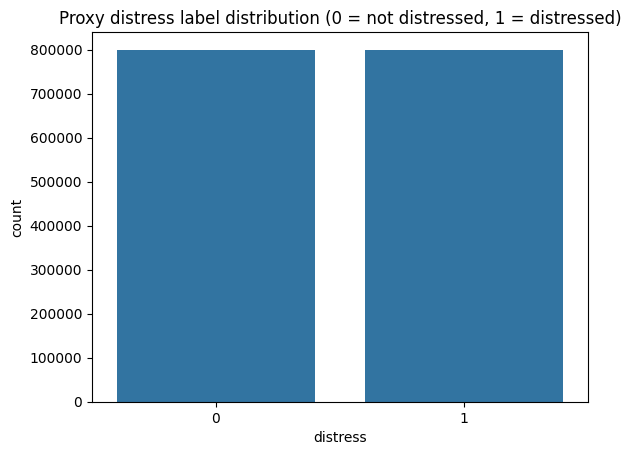

In [3]:
# Quick distribution of original labels
# In Sentiment140: target 0 = negative, 2 = neutral, 4 = positive
print(df['target'].value_counts())

# Map labels to binary distress proxy:
# We'll consider negative(0) -> distress(1), neutral/positive -> not distressed(0)
df['distress'] = df['target'].apply(lambda x: 1 if x==0 else 0)

# Show distribution
display(df[['target','distress']].groupby('distress').size().to_frame('count'))
sns.countplot(x='distress', data=df)
plt.title("Proxy distress label distribution (0 = not distressed, 1 = distressed)")
plt.show()


In [4]:
def clean_tweet(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove mentions and hashtags but keep words
    text = re.sub(r'@\w+|#','', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    tokens = [w for w in text.split() if w not in STOPWORDS]
    return " ".join(tokens)

# Apply cleaning to a small sample to verify it's fast; on full set below
df['clean_text'] = df['text'].astype(str).apply(clean_tweet)
df[['text','clean_text']].head(6)


,text,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats bummer shoulda got david carr third...
1,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
2,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest go bounds
3,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,"@nationwideclass no, it's not behaving at all....",behaving im mad cant see
5,@Kwesidei not the whole crew,whole crew


In [5]:
# The dataset is large (1.6M). For quick iteration, take a balanced sample.
# We'll sample 60k examples with stratification to keep class balance.
sample_size = 60000
df_sample = df.sample(n=sample_size, random_state=42)

# Confirm distress rate
df_sample['distress'].mean()

# Split
X = df_sample['clean_text'].values
y = df_sample['distress'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print("Train size:", len(X_train), "Test size:", len(X_test))


Train size: 48000 Test size: 12000


In [6]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shape:", X_train_tfidf.shape)


TF-IDF shape: (48000, 20000)


In [7]:
# Logistic Regression (baseline)
logreg = LogisticRegression(max_iter=200, solver='saga', n_jobs=-1)
logreg.fit(X_train_tfidf, y_train)
y_pred_lr = logreg.predict(X_test_tfidf)

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)

# Metrics function
def print_metrics(y_true, y_pred, model_name="Model"):
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=3))

print_metrics(y_test, y_pred_lr, "Logistic Regression")
print_metrics(y_test, y_pred_nb, "Naive Bayes")


--- Logistic Regression ---
Accuracy: 0.7634166666666666
F1-score: 0.758444652429167
              precision    recall  f1-score   support

           0      0.753     0.784     0.768      6001
           1      0.775     0.743     0.758      5999

    accuracy                          0.763     12000
   macro avg      0.764     0.763     0.763     12000
weighted avg      0.764     0.763     0.763     12000

--- Naive Bayes ---
Accuracy: 0.7478333333333333
F1-score: 0.748629340421997
              precision    recall  f1-score   support

           0      0.750     0.745     0.747      6001
           1      0.746     0.751     0.749      5999

    accuracy                          0.748     12000
   macro avg      0.748     0.748     0.748     12000
weighted avg      0.748     0.748     0.748     12000



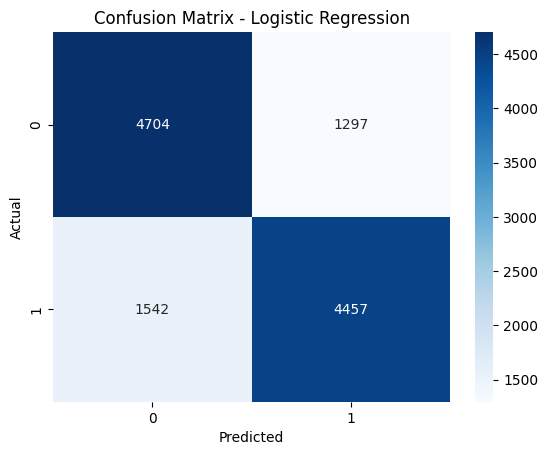

Top features indicative of NOT-distress (positive coef):
sad 8.076
sick 5.578
miss 5.577
cant 5.237
hate 5.236
poor 5.094
missing 4.655
hurts 4.352
wish 4.205
ugh 4.189
bad 3.936
lost 3.909
sucks 3.857
died 3.846
headache 3.786
unfortunately 3.546
didnt 3.532
wont 3.396
sorry 3.364
sadly 3.355

Top features indicative of distress (negative coef):
cant wait -5.681
thanks -4.992
love -3.838
awesome -3.753
yay -3.693
thank -3.673
welcome -3.625
great -3.365
haha -3.261
smile -3.089
glad -2.933
good -2.923
happy -2.92
cute -2.882
enjoy -2.719
loving -2.709
excited -2.706
congrats -2.659
hehe -2.636
nice -2.536


In [8]:
# Confusion matrix for logistic regression
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Plot most informative features (Logistic Regression coefficients)
feature_names = tfidf.get_feature_names_out()
coef = logreg.coef_[0]
top_pos = np.argsort(coef)[-20:]
top_neg = np.argsort(coef)[:20]

print("Top features indicative of NOT-distress (positive coef):")
for i in top_pos[::-1]:
    print(feature_names[i], round(coef[i],3))

print("\nTop features indicative of distress (negative coef):")
for i in top_neg:
    print(feature_names[i], round(coef[i],3))


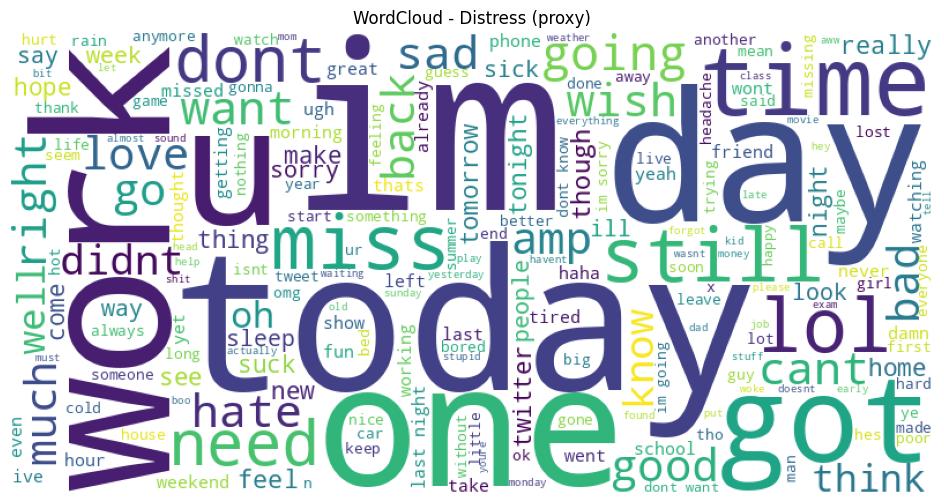

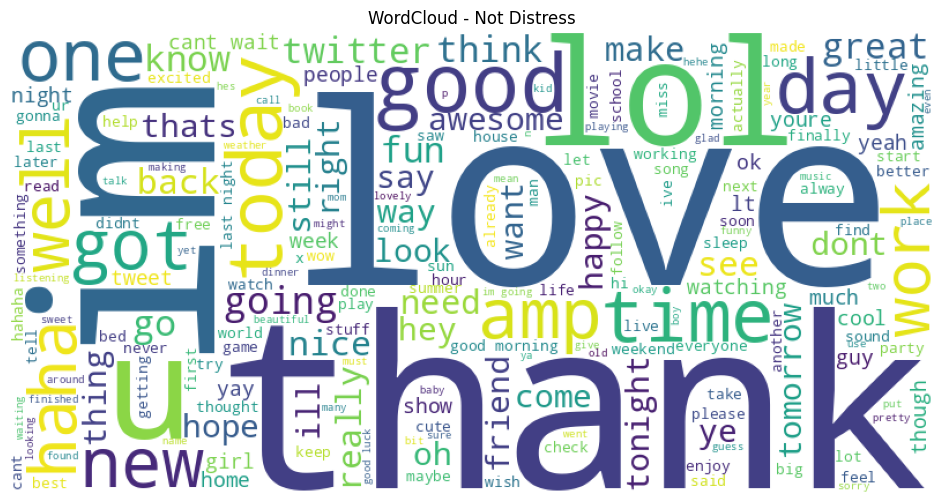

In [9]:
# Word cloud for distress tweets
distress_text = " ".join(df_sample[df_sample['distress']==1]['clean_text'].tolist())
not_distress_text = " ".join(df_sample[df_sample['distress']==0]['clean_text'].tolist())

wc1 = WordCloud(width=800, height=400, background_color='white').generate(distress_text)
plt.figure(figsize=(12,6)); plt.imshow(wc1); plt.axis('off'); plt.title("WordCloud - Distress (proxy)"); plt.show()

wc2 = WordCloud(width=800, height=400, background_color='white').generate(not_distress_text)
plt.figure(figsize=(12,6)); plt.imshow(wc2); plt.axis('off'); plt.title("WordCloud - Not Distress"); plt.show()


In [10]:
import joblib
os.makedirs("/content/model", exist_ok=True)
joblib.dump(logreg, "/content/model/logreg_sentiment_proxy.joblib")
joblib.dump(tfidf, "/content/model/tfidf_vectorizer.joblib")
print("Saved model and vectorizer to /content/model")


Saved model and vectorizer to /content/model


In [11]:
def predict_text(text):
    cleaned = clean_tweet(text)
    vec = tfidf.transform([cleaned])
    pred = logreg.predict(vec)[0]
    prob = logreg.predict_proba(vec)[0][1]
    return {"text": text, "cleaned": cleaned, "distress_proxy": int(pred), "score": float(prob)}

# Try few examples
samples = [
    "I feel so alone and tired of everything",
    "Had an amazing day with friends!",
    "I can't sleep and I'm so worried all the time"
]
for s in samples:
    print(predict_text(s))


{'text': 'I feel so alone and tired of everything', 'cleaned': 'feel alone tired everything', 'distress_proxy': 1, 'score': 0.9753164215383651}
{'text': 'Had an amazing day with friends!', 'cleaned': 'amazing day friends', 'distress_proxy': 0, 'score': 0.21365780179705812}
{'text': "I can't sleep and I'm so worried all the time", 'cleaned': 'cant sleep im worried time', 'distress_proxy': 1, 'score': 0.9438435951360897}
